# Week 8 - Semantic Networks

intro...

# Note

Getting igraph to make plots was a lot of work, the steps I ended up with are:

+ install `cairocffi`, remove `pycairo` if present
+ install `igraph` version `0.7.1` from the github repo, **Do not** use the pypi version, there is a [known issue](https://github.com/igraph/python-igraph/issues/89)

For this notebook we will be using the following packages.

In [1]:
import nltk
import sklearn
import pandas
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn
import igraph as ig

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with lets create an undirected graph

In [2]:
g = ig.Graph()
g

We can add vertices, they are all numbered starting at 0 so this will add vertices `0`, `1` and `2`.

In [3]:
g.add_vertices(3)

Now we have 3 vertices

In [4]:
g.vcount()

3

Or if we want to get more information about the graph

In [5]:
print(g.summary())

IGRAPH U--- 3 0 -- 


We can give vertices names, or even give the graph a name.

In [6]:
g.vs['name'] = ['a', 'b', 'c'] #vs stands for VertexSeq(uence)

Now we can get vertices by name

In [7]:
g.vs.find('a')

igraph.Vertex(<igraph.Graph object at 0x115857228>, 0, {'name': 'a'})

Still pretty boring though

Lets add a couple of edges, notice we can use names or ids

In [8]:
g.add_edges([(0,1), (1,2), ('a', 'c')])
print(g.summary())

IGRAPH UN-- 3 3 -- 
+ attr: name (v)


Notice the summary has changed

We can also give the edges properties, but instead of names we give weights

In [9]:
print("Before weighted", g.is_weighted())
g.es['a', 'b']['weight'] = 4
g.es['a', 'c']['weight'] = 10
print("After weighted", g.is_weighted())

Before weighted False
After weighted True


Let's visualize it

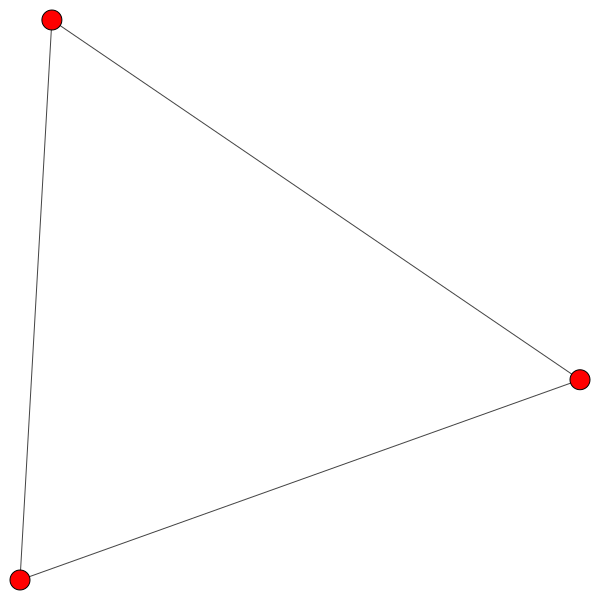

In [10]:
ig.plot(g)

Very exciting

There are a large number of things to do with the graph once we have created it, but we have to move on to using them now.

First lets load our data, the Grimmer corpus

In [11]:
senReleasesDF = pandas.read_csv('data/senReleasesTraining.csv', index_col = 0)[:5]
senReleasesDF[:5]

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We will be extracting sentences, as well as tokenizing and stemming

In [12]:
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None, vocab = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)

    #We will return a list with the stopwords removed
    if vocab is not None:
        vocab_str = '|'.join(vocab)
        workingIter = (w for w in workingIter if re.match(vocab_str, w))

    return list(workingIter)

stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')
wordnet = nltk.stem.WordNetLemmatizer()

For now we will not be dropping any stop words

In [13]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [normlizeTokens(s, stopwordLst = None, stemmer = snowball) for s in x])

senReleasesDF[:5]

,download_url,html_url,name,path,text,targetSenator,tokenized_sents,normalized_sents
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[for, immedi, releas, for, immedi, releas, co..."
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[for, immedi, releas, for, immedi, releas, co..."
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[for, immedi, releas, for, immedi, releas, wa..."
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[for, immedi, releas, for, immedi, releas, wa..."
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[for, immedi, releas, for, immedi, releas, co..."


Lets start by lookking at words co-occurring in same sentences

In [14]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        edges = list(zip(*np.where(coOcMat)))
        weights = coOcMat[np.where(coOcMat)]
        g = ig.Graph( n = len(wordLst),
            edges = edges,
            vertex_attrs = {'name' : wordLst, 'label' : wordLst},
            edge_attrs = {'weight' : weights}
            )

        return g

SyntaxError: invalid syntax (<ipython-input-14-a4fde83d631b>, line 10)

In [15]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:2].sum())

NameError: name 'wordCooccurrence' is not defined

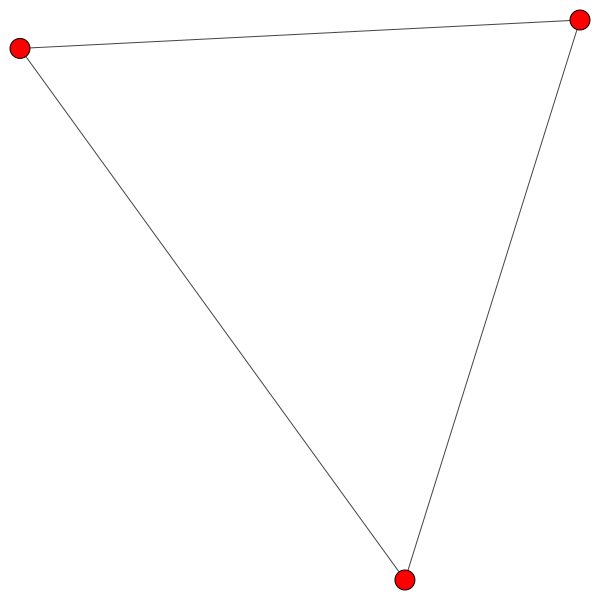

In [16]:
ig.plot(g)